In [82]:
import warnings
import pandas_datareader as pdr
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams

import seaborn as sns
import os
import datetime


### Import Data of energy consumption in Megawatts (MW) of American Electric Power (AEP) 

In [104]:
data = pd.read_csv("AEP_hourly.csv")

In [105]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [106]:
## check data types
data.dtypes

Datetime     object
AEP_MW      float64
dtype: object

In [107]:
data["Date"] = pd.to_datetime(data["Datetime"]).dt.date
data["Time"] = pd.to_datetime(data["Datetime"]).dt.time

In [108]:
data.head()

,Datetime,AEP_MW,Date,Time
0,2004-12-31 01:00:00,13478.0,2004-12-31,01:00:00
1,2004-12-31 02:00:00,12865.0,2004-12-31,02:00:00
2,2004-12-31 03:00:00,12577.0,2004-12-31,03:00:00
3,2004-12-31 04:00:00,12517.0,2004-12-31,04:00:00
4,2004-12-31 05:00:00,12670.0,2004-12-31,05:00:00


In [109]:
data.tail()

,Datetime,AEP_MW,Date,Time
121268,2018-01-01 20:00:00,21089.0,2018-01-01,20:00:00
121269,2018-01-01 21:00:00,20999.0,2018-01-01,21:00:00
121270,2018-01-01 22:00:00,20820.0,2018-01-01,22:00:00
121271,2018-01-01 23:00:00,20415.0,2018-01-01,23:00:00
121272,2018-01-02 00:00:00,19993.0,2018-01-02,00:00:00


In [110]:
## check is there any null data
data.isnull().sum()

Datetime    0
AEP_MW      0
Date        0
Time        0
dtype: int64

In [111]:
df1 = data

In [112]:
df1[df1["AEP_MW"] == data["AEP_MW"].max()]

,Datetime,AEP_MW,Date,Time
30221,2008-10-20 14:00:00,25695.0,2008-10-20,14:00:00


In [113]:
df1[df1["AEP_MW"] == data["AEP_MW"].min()]

,Datetime,AEP_MW,Date,Time
100759,2016-10-02 05:00:00,9581.0,2016-10-02,05:00:00


In [114]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Data Preprocessing: Indexing with Time Series Data

In [115]:
data_date = data.groupby('Date')['AEP_MW'].sum().reset_index()

In [116]:

data_date = data_date.set_index('Date')
data_date.index

Index([2004-10-01, 2004-10-02, 2004-10-03, 2004-10-04, 2004-10-05, 2004-10-06,
       2004-10-07, 2004-10-08, 2004-10-09, 2004-10-10,
       ...
       2018-07-25, 2018-07-26, 2018-07-27, 2018-07-28, 2018-07-29, 2018-07-30,
       2018-07-31, 2018-08-01, 2018-08-02, 2018-08-03],
      dtype='object', name='Date', length=5055)

In [117]:
## Convert data types to datetime
data_date.index = pd.to_datetime(data_date.index) 

In [118]:
data_month = data_date['AEP_MW'].resample('MS').mean() ## resample data monthly
data_month.tail()

Date
2018-04-01    327341.866667
2018-05-01    338808.129032
2018-06-01    367326.000000
2018-07-01    382238.935484
2018-08-01    251647.000000
Freq: MS, Name: AEP_MW, dtype: float64

## Visualizing Energy Consumption (Megawatts) Time Series Data

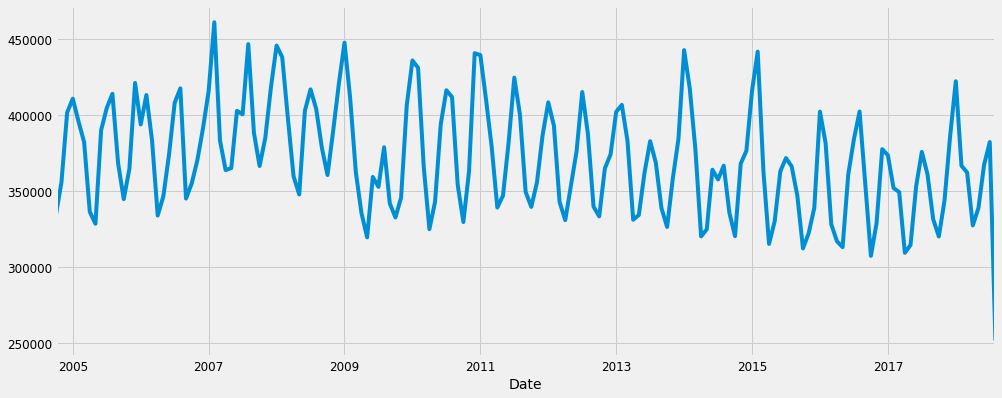

In [119]:
data_month.plot(figsize=(15, 6))
plt.show()

The plot shows that it looks like it has a good stationarity: doesn't have an obvious trend. Let's decompose the time series into three distinct components: trend, seasonality, and noise to take a close look.

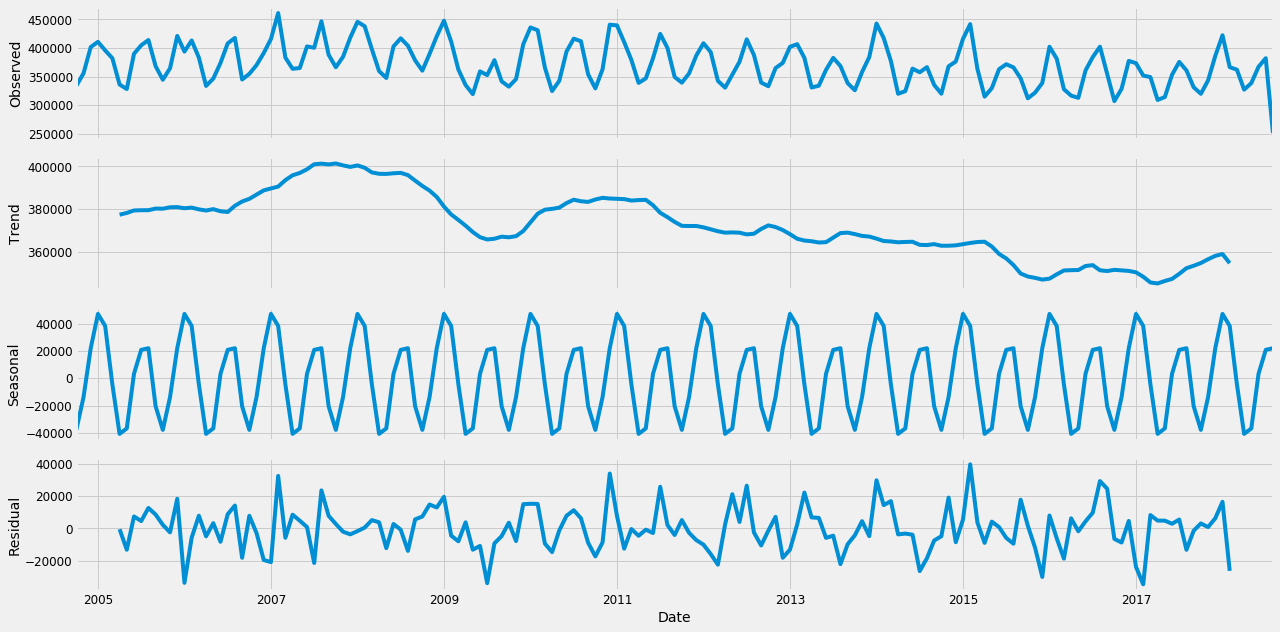

In [120]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 9
decomposition = sm.tsa.seasonal_decompose(data_month, model='additive')
fig = decomposition.plot()
plt.show()

The time series doesn't have a good enough stationaity. It has a trend, and also is seasonal. Let's take a look at the autocorrelation plot.

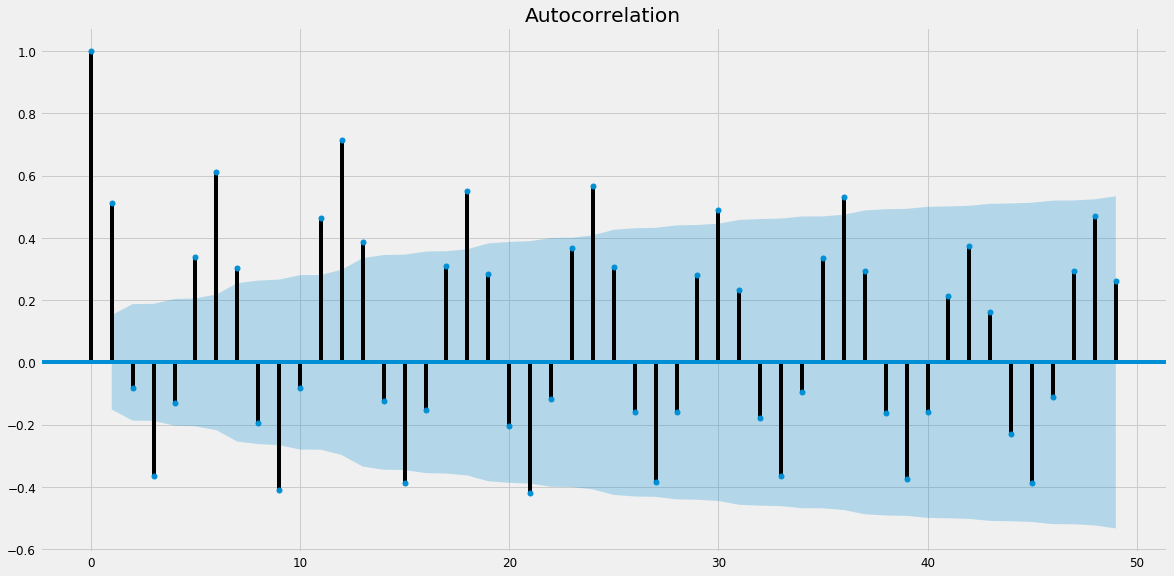

In [122]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_month, lags = range(0,50)).show()

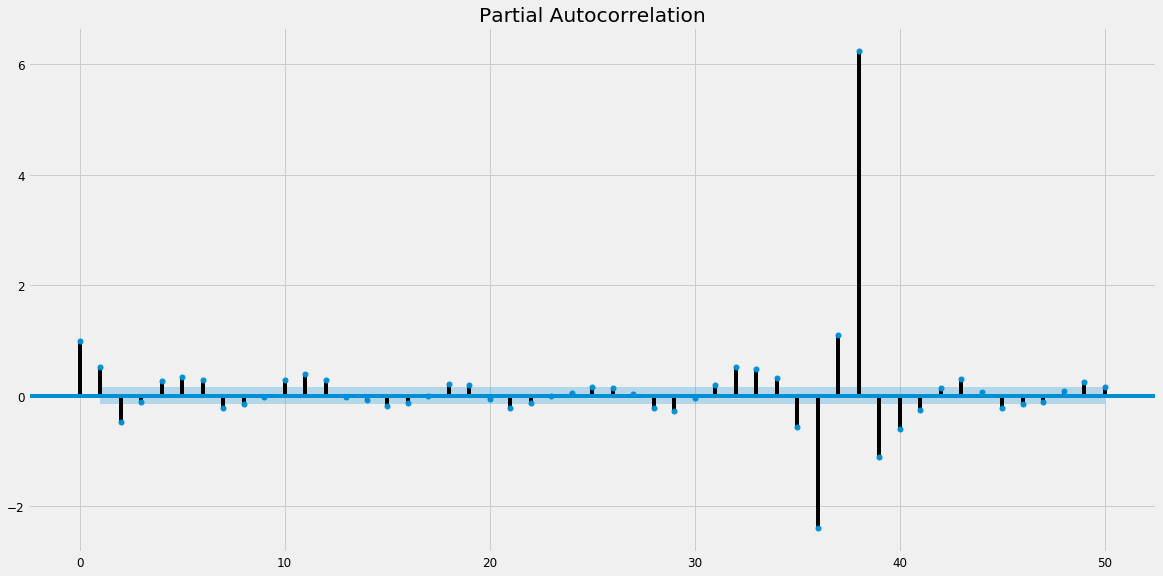

In [123]:
plot_pacf(data_month, lags=50)
plt.show()

The autocorrelation doesn't have either "cut off" or "tail off" characteristics. 

In [126]:
from statsmodels.tsa.stattools import adfuller as ADF
print(ADF(data_month))

(-0.5842575253497144, 0.8744996518706418, 12, 154, {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}, 3441.9834237484615)


The P-value is mucu larger than the significant level 0.05 and the ADF Test result is larger than all 1%, 5% and 10% level. So we fail to reject the null hypothesis that unit root does exist. The time series is not stationarity.

## Take First-Differencing to Make Time Series Data Stationarity

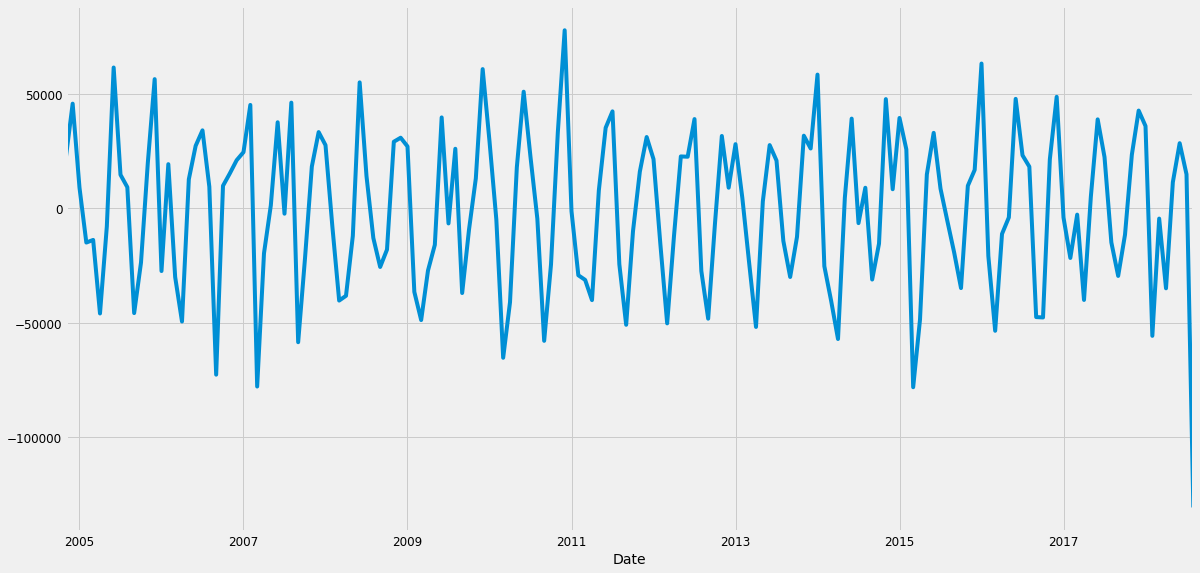

In [181]:
D_data = data_month.diff().dropna()  ### 1st Differencing
D_data.columns = ['diff']  
D_data.plot()

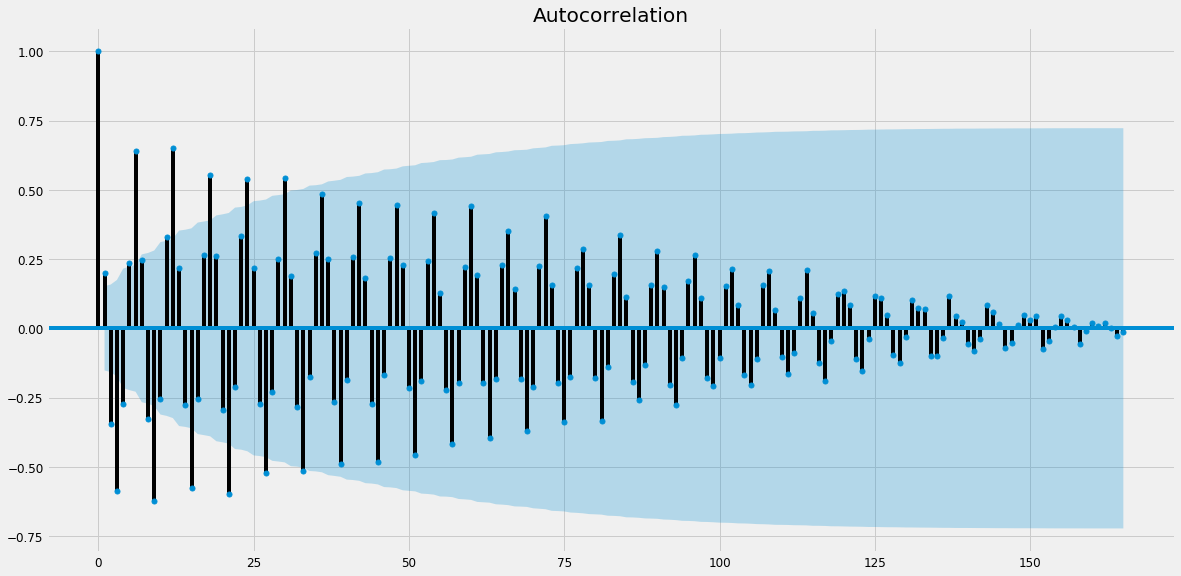

In [183]:
plot_acf(D_data).show()

In [129]:
print(ADF(D_data))

(-5.693851279820266, 7.957095930638674e-07, 11, 154, {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}, 3416.0839269572116)


After 1st differencing, the autocorrelation plot has a "tail off" Characteristics. The ADF test result is smaller than  all 1%, 5% and 10% level and the p-value is closed to 0. So we can  reject the null hypothesis that unit root does exist. The time series is  stationarity.

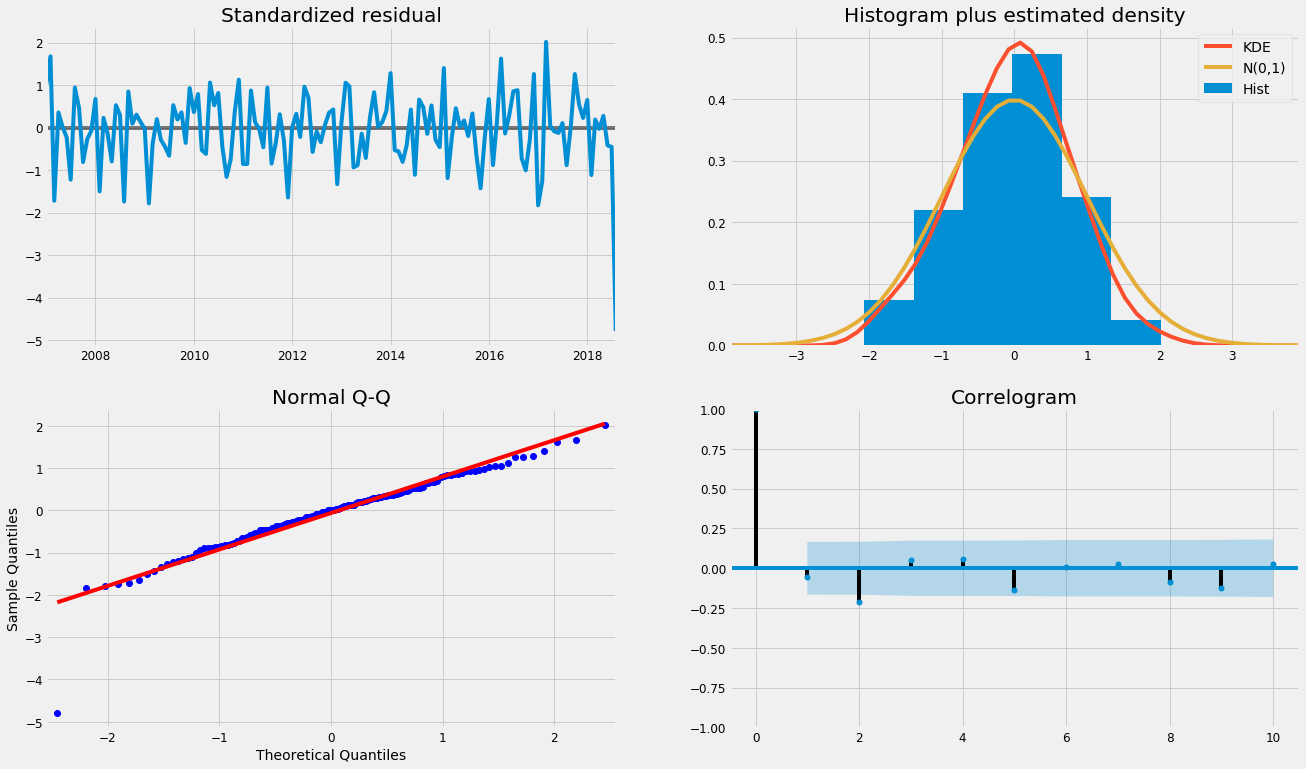

In [130]:
## 

ARIMA = sm.tsa.statespace.SARIMAX(D_data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = ARIMA.fit()

results.plot_diagnostics(figsize=(20, 12))
plt.show()

## Start to predict Energy Consumption in Monthly

In [135]:
mod = sm.tsa.statespace.SARIMAX(data_month,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3196      0.144      2.218      0.027       0.037       0.602
ma.L1         -0.7659      0.077     -9.888      0.000      -0.918      -0.614
ar.S.L12      -0.2402      0.068     -3.523      0.000      -0.374      -0.107
sigma2      5.436e+08   2.04e-10   2.67e+18      0.000    5.44e+08    5.44e+08


Each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

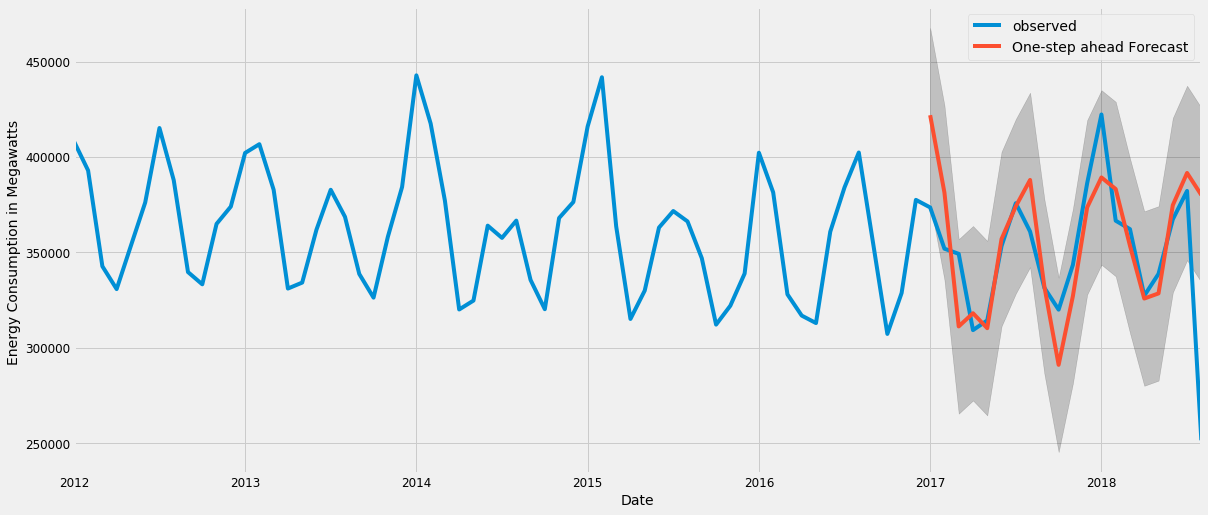

In [142]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data_month['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', figsize=(18, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_ylabel('Energy Consumption in Megawatts ')
plt.legend()
plt.show()

The line plot is showing the observed energy consumption from 2012 to 2018 compared to the rolling forecast predictions. Overall, the forecasts align with the true values well.

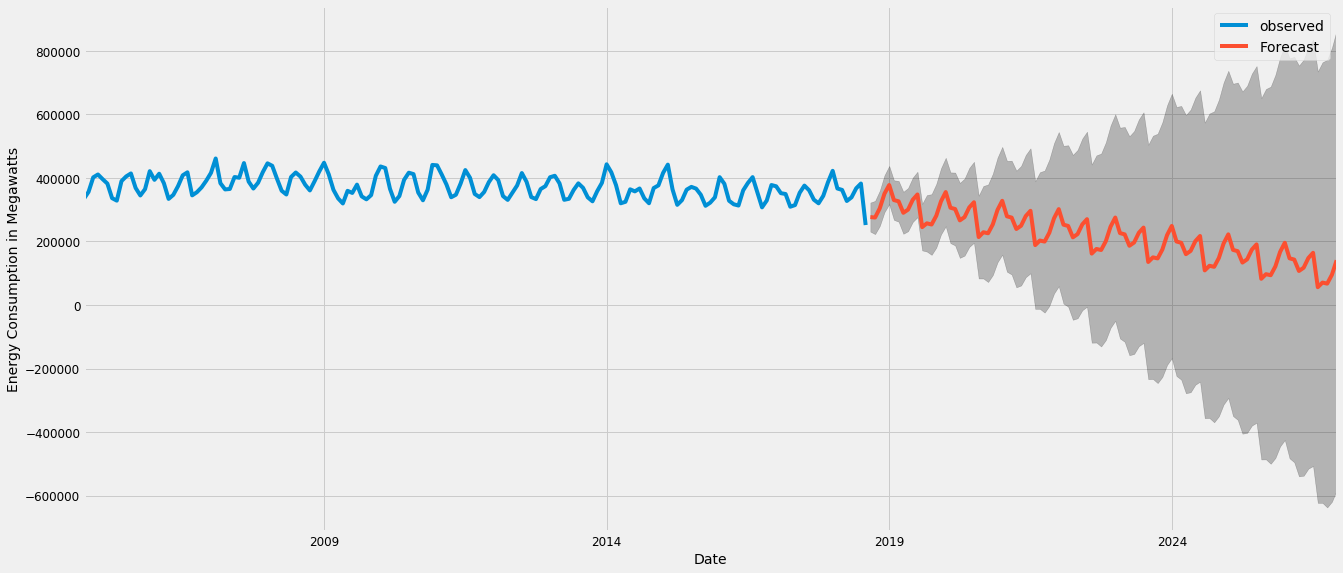

In [139]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = data_month.plot(label='observed', figsize=(20, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_ylabel('Energy Consumption in Megawatts')
plt.legend()
plt.show()

The model clearly captured energy consumption seasonality. As the forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Now let's analyze the data in hour.

In [184]:
from datetime import datetime
AEP = pd.read_csv("AEP_hourly.csv")
AEP.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [185]:
AEP['Datetime'] = pd.to_datetime(AEP['Datetime'])
rng = (AEP['Datetime'] >= '2017-12-21') & (AEP['Datetime'] <= '2018-01-02')
AEP = AEP.loc[rng]
AEP.head()

,Datetime,AEP_MW
107378,2017-12-31 01:00:00,17422.0
107379,2017-12-31 02:00:00,17219.0
107380,2017-12-31 03:00:00,17313.0
107381,2017-12-31 04:00:00,17396.0
107382,2017-12-31 05:00:00,17512.0


In [186]:
AEP.dtypes

Datetime    datetime64[ns]
AEP_MW             float64
dtype: object

In [187]:
AEP.describe()

,AEP_MW
count,289.000000
mean,16728.778547
std,2223.379717
min,11832.000000
25%,14804.000000
50%,16997.000000
75%,18601.000000
max,21089.000000


In [188]:
AEP = AEP.groupby('Datetime')['AEP_MW'].sum().reset_index()


In [189]:
AEP = AEP.set_index('Datetime')

In [190]:
hourly = AEP['AEP_MW'].resample('H').mean()

In [191]:
hourly.head()

Datetime
2017-12-21 00:00:00    15186.0
2017-12-21 01:00:00    14729.0
2017-12-21 02:00:00    14463.0
2017-12-21 03:00:00    14456.0
2017-12-21 04:00:00    14520.0
Freq: H, Name: AEP_MW, dtype: float64

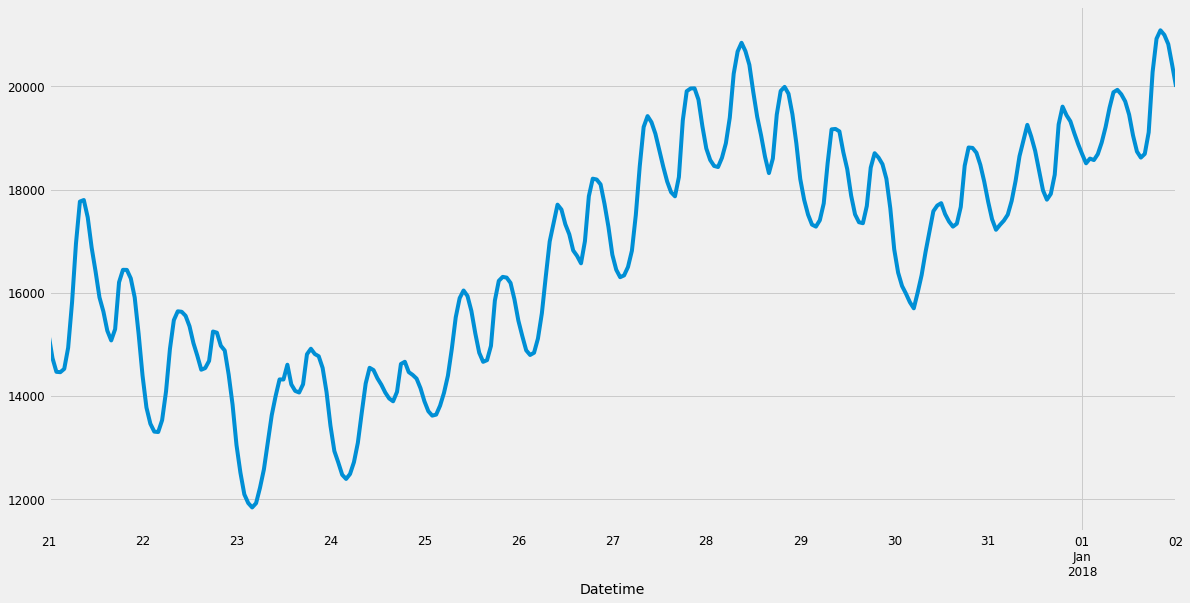

In [192]:
hourly.plot(figsize=(18, 9))
plt.show()

In [193]:
hourly.isnull().sum()

0

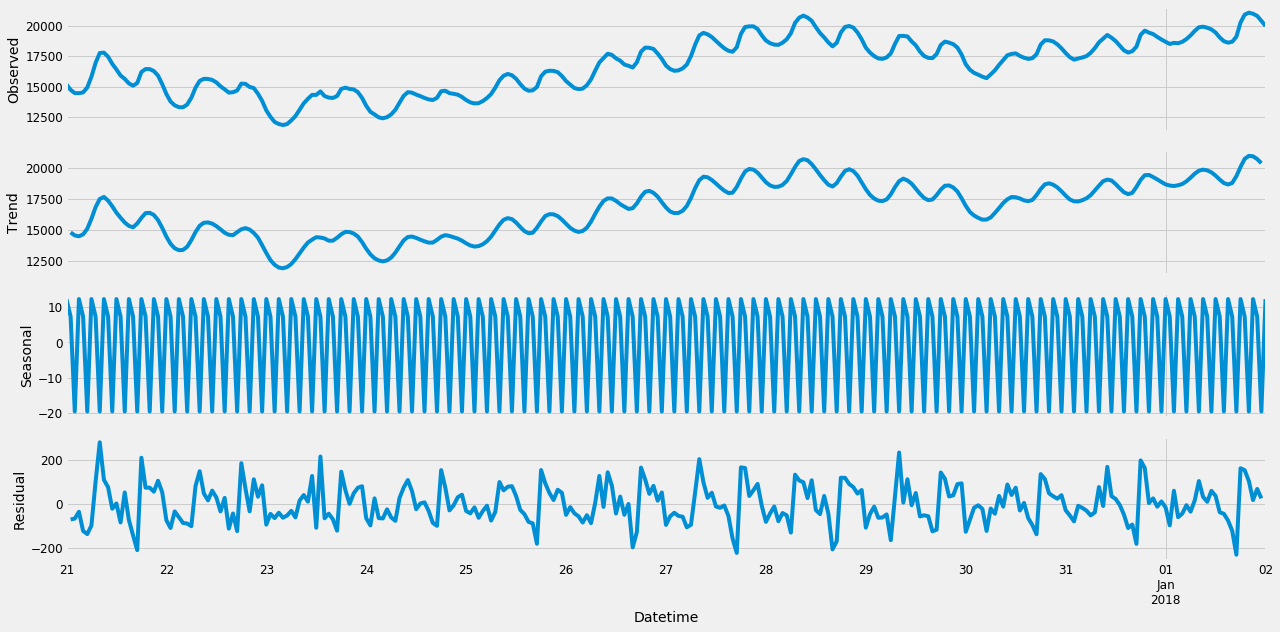

In [194]:
rcParams['figure.figsize'] = 18, 9
decomposition_hourly = sm.tsa.seasonal_decompose(hourly, model='additive',freq=3)
fig = decomposition_hourly.plot()
plt.show()

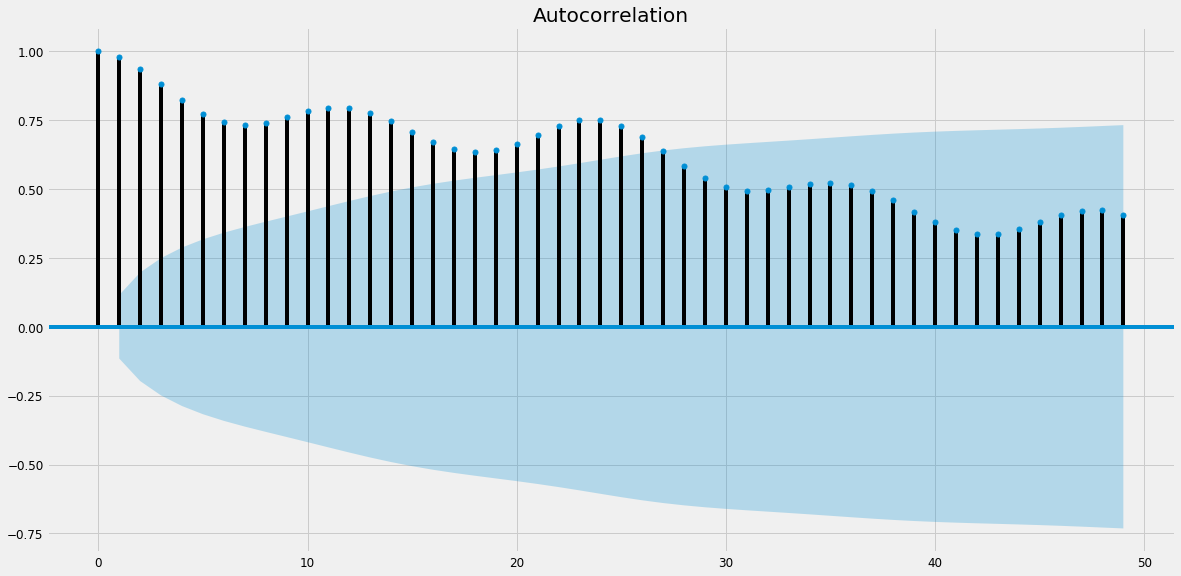

In [195]:
plot_acf(hourly, lags = range(0,50)).show()

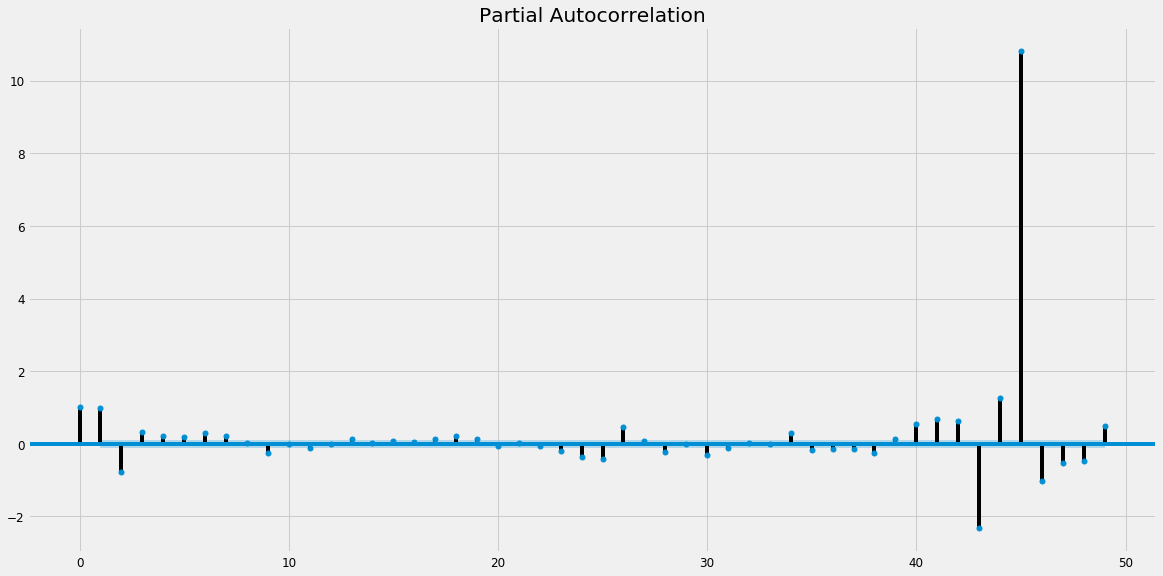

In [196]:
plot_pacf(hourly, lags = range(0,50)).show()

The time series is absolutely not stationarity.

In [197]:
print(ADF(hourly))

(-0.33411719107763516, 0.9205313993296605, 16, 272, {'1%': -3.4546223782586534, '5%': -2.8722253212300277, '10%': -2.5724638500216264}, 3677.4897299633317)


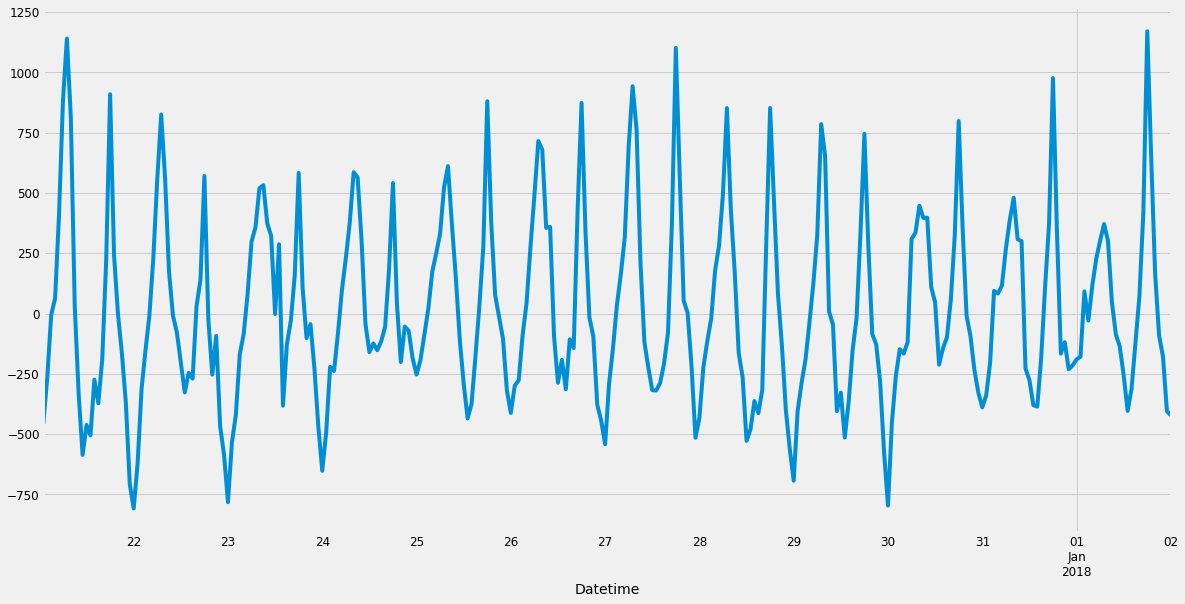

In [198]:
D_data = hourly.diff().dropna() 
D_data.columns = ['diff']  
D_data.plot()

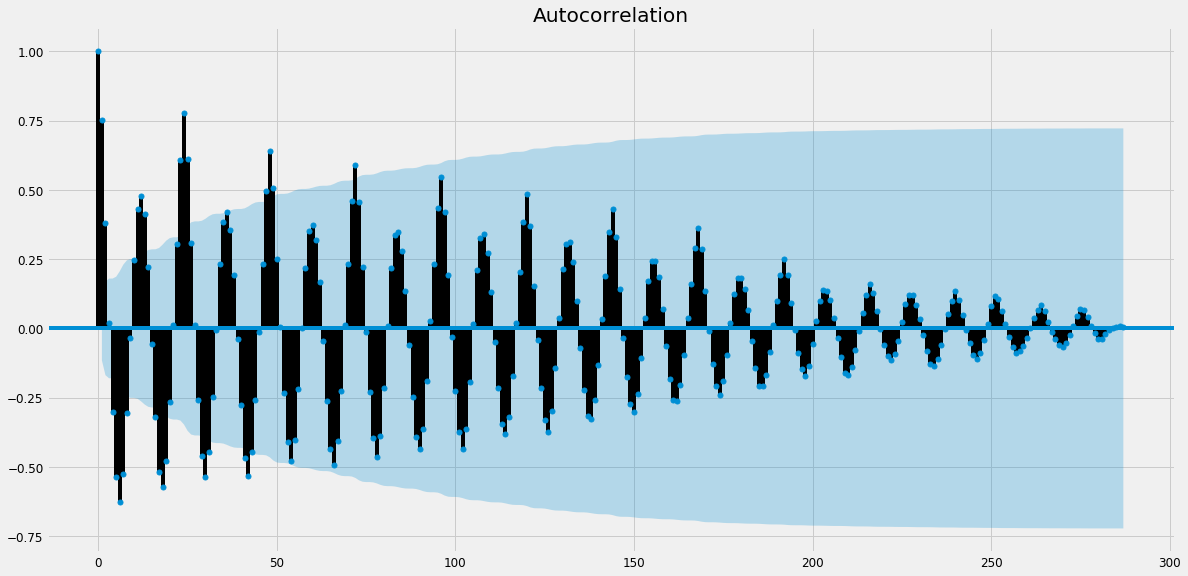

In [199]:
plot_acf(D_data).show()

In [200]:
print(ADF(D_data))

(-6.741045852029269, 3.1182936639025717e-09, 16, 271, {'1%': -3.4547128138328875, '5%': -2.8722649771800155, '10%': -2.5724850011573914}, 3650.9087865879224)


In [201]:
ARIMA = sm.tsa.statespace.SARIMAX(D_data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = ARIMA.fit()

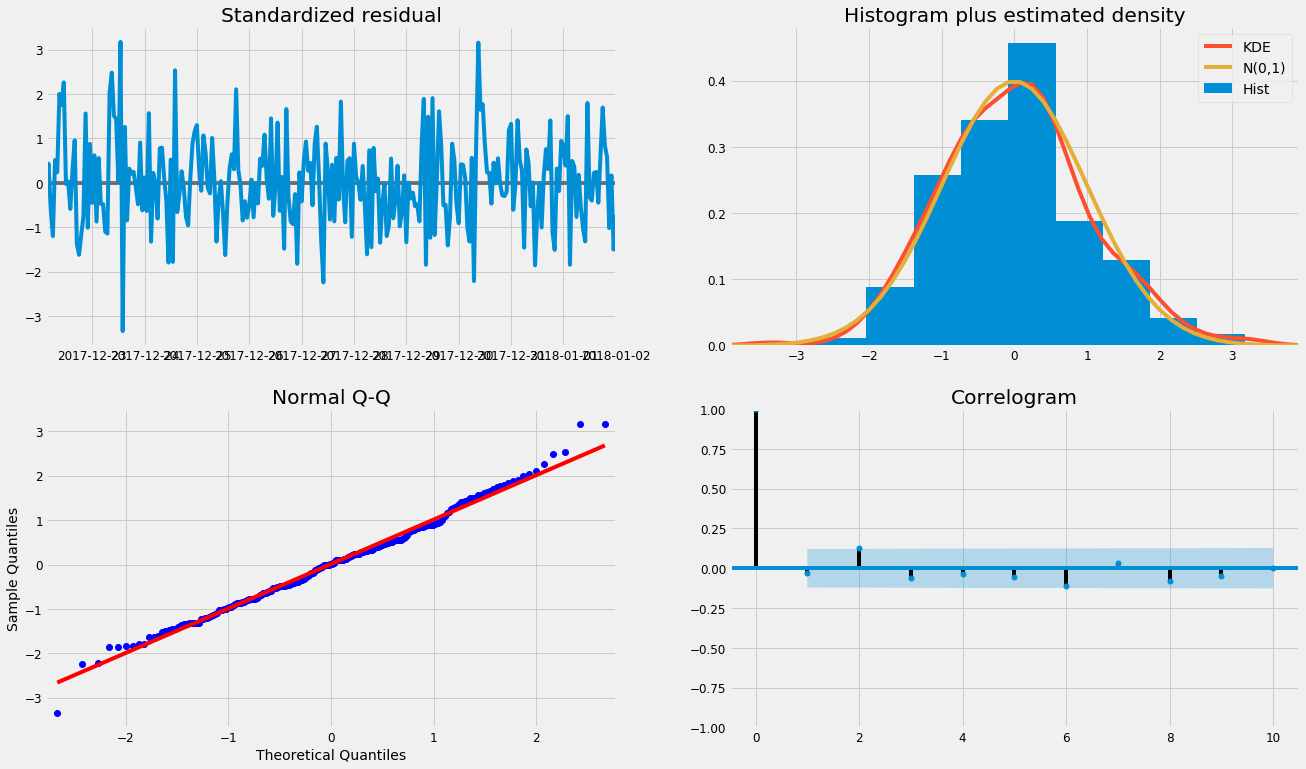

In [202]:
results.plot_diagnostics(figsize=(20, 12))
plt.show()

In [203]:
mod = sm.tsa.statespace.SARIMAX(hourly,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6119      0.072      8.502      0.000       0.471       0.753
ma.L1         -0.0553      0.090     -0.615      0.538      -0.231       0.121
ar.S.L12      -0.8562      0.030    -28.080      0.000      -0.916      -0.796
sigma2      2.173e+04   1818.213     11.951      0.000    1.82e+04    2.53e+04


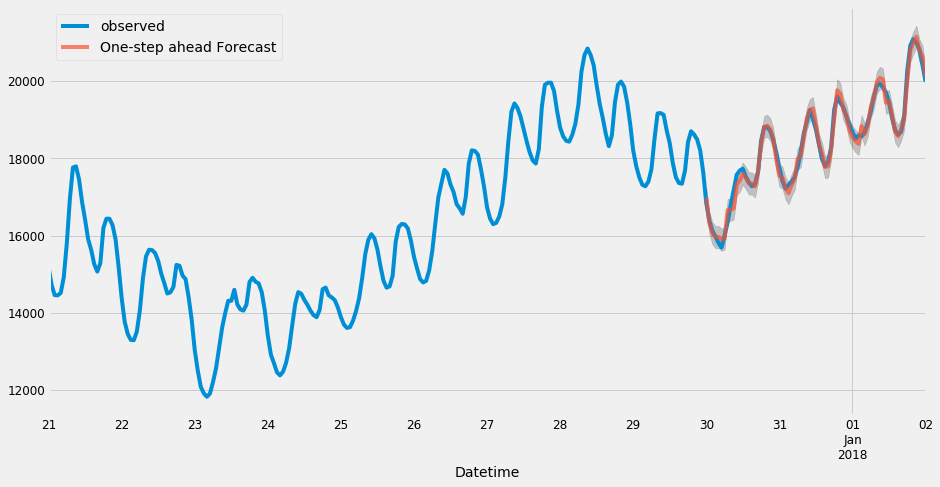

In [204]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
ax = hourly['2017-12-21 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
plt.show()

Overall, the forecasts align with the true values very well

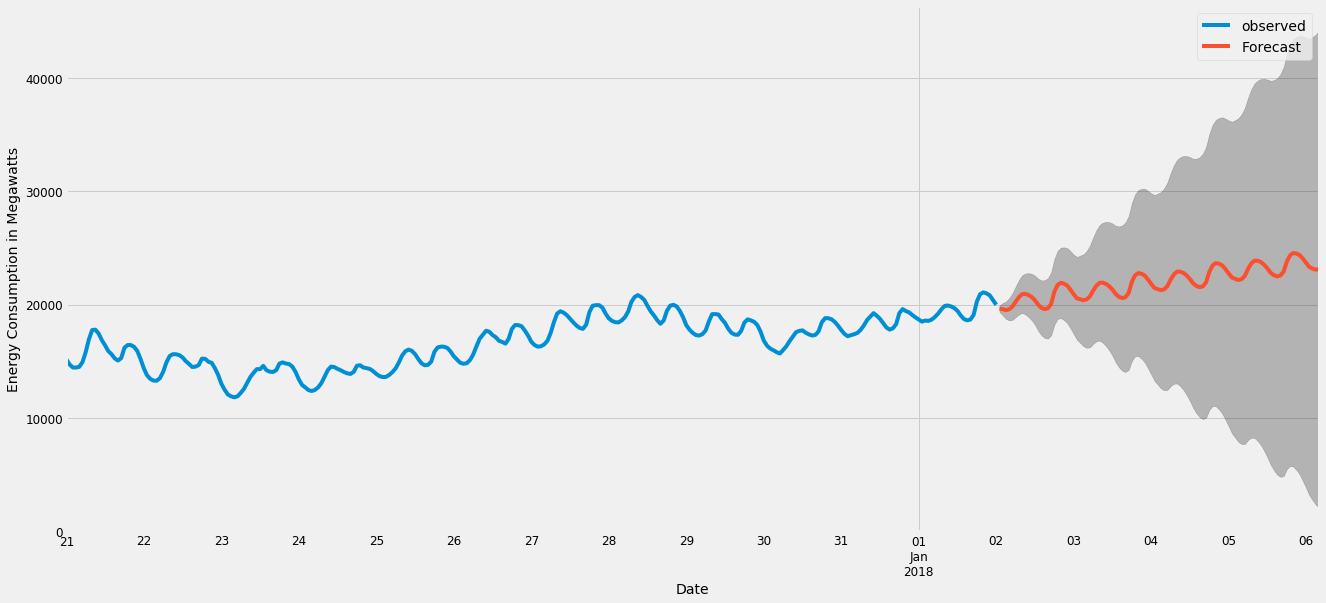

In [205]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = hourly.plot(label='observed', figsize=(20, 9))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption in Megawatts')
plt.legend()
plt.show()